## Supplementary Figure - Marginal Emissions 2
Siobhan Powell, 2021.

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import pickle

In [3]:
from simple_dispatch import bidStack
import matplotlib
import scipy
from future_grid import FutureDemand

In [4]:
unit_drops = pd.read_csv('IntermediateOutputs/scheduled_retirements_2019.csv', index_col=0)
additions_df = pd.read_csv('IntermediateOutputs/generator_additions.csv', index_col=0)
import copy
def drop_add_generators(future_year, gd_short_init, unit_drops=None, additions_df=None, drop=True, add=True):
    
    gd_short_final = copy.deepcopy(gd_short_init)
    if add:
        added_units = additions_df[additions_df['Year']<future_year]['orispl_unit'].values
        for i, val in enumerate(added_units):
            idx = len(gd_short_final.df)
            loc1 = gd_short_final.df[gd_short_final.df['orispl_unit']==val].index
            gd_short_final.df = pd.concat((gd_short_final.df, gd_short_final.df.loc[loc1]), ignore_index=True)
            gd_short_final.df.loc[idx, 'orispl_unit'] = 'added_'+str(i)
        
    if drop:
        dropped_units = unit_drops[unit_drops['retirement_year']<future_year]['orispl_unit'].values
        gd_short_final.df = gd_short_final.df[~gd_short_final.df['orispl_unit'].isin(dropped_units)].copy(deep=True).reset_index(drop=True)
    
    return gd_short_final

In [5]:
year = 2035; solar = 3.5; wind = 3; run_year=2019
gd_short = pickle.load(open('IntermediateOutputs/generator_data_short_%s_%s.obj'%('WECC', str(run_year)), 'rb'))
gd_short_copy = drop_add_generators(year, gd_short, drop=True, unit_drops=unit_drops, add=True, additions_df=additions_df)

# Plotting

In [6]:
def set_up_generator(year=2035, fuel=1.0, gd_short_copy=None):
    
    if gd_short_copy is not None:
        return gd_short_copy
    else:
        if year != 2019:
            gd_short_copy = drop_add_generators(year, gd_short, drop=True, unit_drops=unit_drops, add=True, additions_df=additions_df)
        else:
            gd_short_copy = copy.deepcopy(gd_short)
    
    return gd_short_copy

def set_up_scenario(year=2035, solar=3.5, wind=3, fuel=1.0, ev_pen=0.5, 
                    ev_scenario='HighHome', ev_timers='', ev_workplace_control='', 
                    ev_workplace_bool=False, evs_bool=True, ev_scenario_date='20220408', gd_short_copy=None):
    
    gd_short_copy = set_up_generator(year=year, fuel=fuel, gd_short_copy=gd_short_copy)
    future = FutureDemand(gd_short_copy, year=year)
    if year != 2019:
        future.electrification(scale_vs_given=True)
    future.solar_multiplier[year] = solar
    future.wind_multiplier[year] = wind
    future.solar()
    future.wind()
    
    if evs_bool:
        if ev_workplace_bool:
            future.evs(pen_level=ev_pen, scenario_name=ev_scenario, timers_extra_info=ev_timers, wp_control=ev_workplace_control, scenario_date=ev_scenario_date)
        else:
            future.evs(pen_level=ev_pen, scenario_name=ev_scenario, timers_extra_info=ev_timers, scenario_date=ev_scenario_date)
    
    future.update_total()
    
    return gd_short_copy, future

In [17]:
def subplot_1(scenario, ax, week, ylim1=[150, 350], ylim2=[400,700], showy2=True, y2lab=None, penlevel=0.5):
    
    colors3 = ['#d7301f', '#fc8d59', '#91cf60', '#737373', '#9ebcda', '#88419d']

    ax2 = ax.twinx()

    for i, scenario2 in enumerate(['Timers9pm_noWPcontrol', 'Timers12am_noWPcontrol', 'TimersRandom_noWPcontrol', 'TimersNone_noWPcontrol', 'TimersNone_WPcontrol_minpeak', 'TimersNone_WPcontrol_avgem']):#AllAtHomeL2Access', 'BaseCase_NoL1', 'LessHome_MoreWork', 'LessHome_ConstantWork']):

        try:
            save_str = 'Results/Fuel1_Solar35_Wind3/fuel1_solar3.5_wind3_'+scenario+'_'+scenario2+'_penlevel'+str(penlevel)+'_storagebefore'
            test_dpdf = pd.read_csv(save_str+'_withstorage_dpdf_20220408.csv')
        except:
            save_str = 'Results/Fuel1_Solar35_Wind3/fuel1_solar3.5_wind3_'+scenario+'_'+scenario2+'_penlevel'+str(penlevel)+'_storagebefore_withstorage'
            test_dpdf = pd.read_csv(save_str+'_withstorage_dpdf_20220408.csv')
        subset = test_dpdf.loc[(pd.to_datetime(test_dpdf['datetime']).dt.weekday.isin([0, 1, 2, 3, 4]))&(pd.to_datetime(test_dpdf['datetime']).dt.week==week)]
        ax.plot(np.mean(np.reshape(subset['co2_tot'].values / subset['total_incl_noncombustion'].values, (-1, 24)), axis=0), linestyle='-', color=colors3[i])
        ax2.plot(np.mean(np.reshape(subset['co2_marg'].values, (-1, 24)), axis=0), linestyle='--', color=colors3[i])
    
    if not showy2:
        ax2.set_yticks([])
    ax.set_ylim(ylim1)
    ax2.set_ylim(ylim2)
    if y2lab is not None:
        ax2.set_ylabel(y2lab)

    return ax

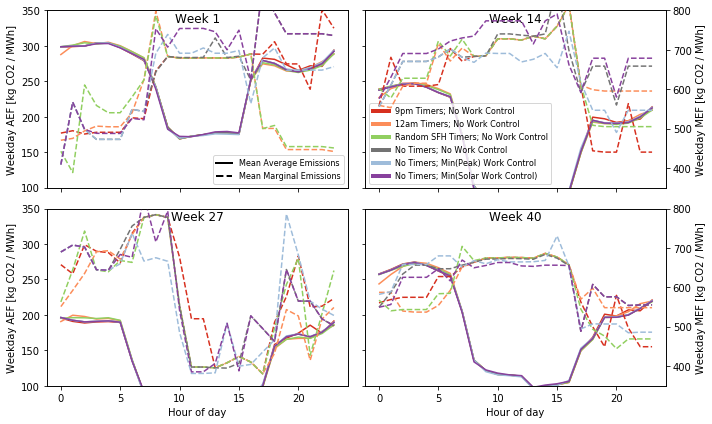

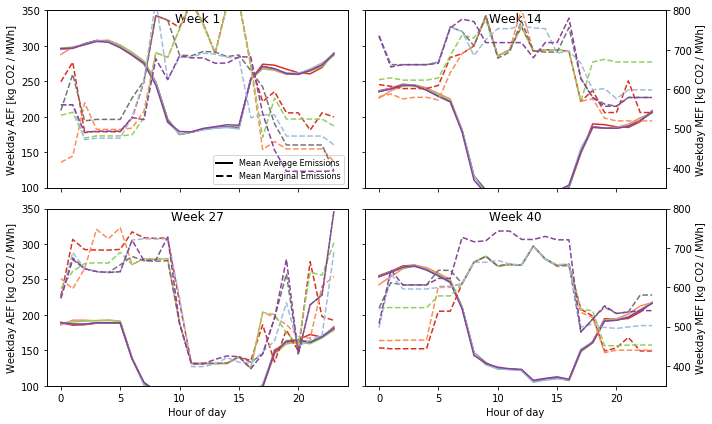

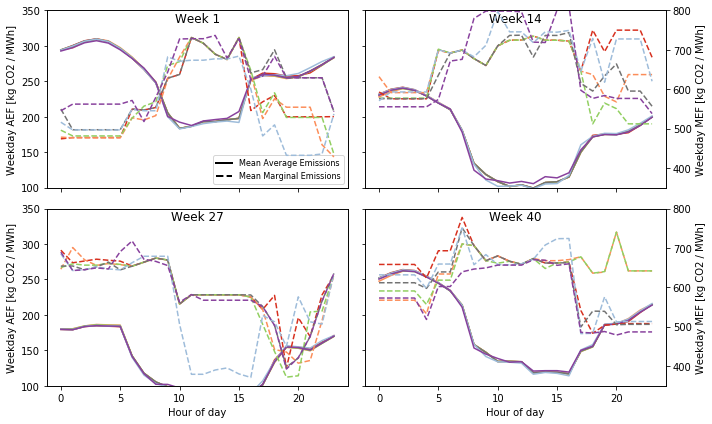

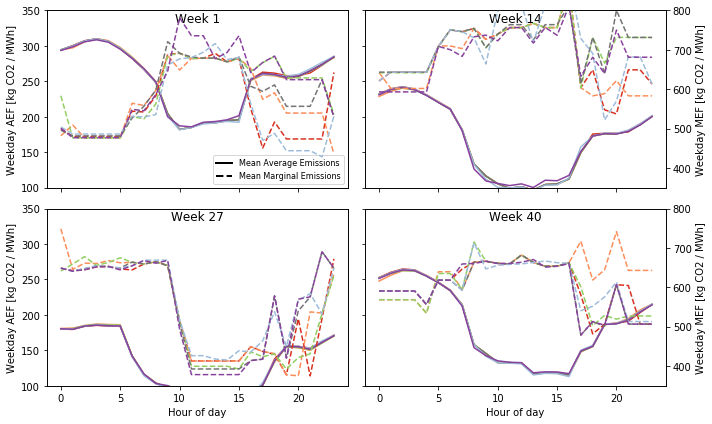

In [18]:
for scenario in ['UniversalHome', 'HighHome', 'LowHome_HighWork', 'LowHome_LowWork']:

    fig, axes = plt.subplots(2, 2, figsize=(10,6), sharex=True, sharey=True)
    colors = ['#a6611a', '#dfc27d', '#80cdc1', '#018571']
    colors3 = ['#d7301f', '#fc8d59', '#91cf60', '#737373', '#9ebcda', '#88419d']

    axes[0, 0] = subplot_1(scenario, axes[0, 0], 1, ylim1=[100, 350], ylim2=[350,800], showy2=False)
    axes[0, 1] = subplot_1(scenario, axes[0, 1], 14, ylim1=[100, 350], ylim2=[350,800], y2lab='Weekday MEF [kg CO2 / MWh]')
    axes[1, 0] = subplot_1(scenario, axes[1, 0], 27, ylim1=[100, 350], ylim2=[350,800], showy2=False)
    axes[1, 1] = subplot_1(scenario, axes[1, 1], 40, ylim1=[100, 350], ylim2=[350,800], y2lab='Weekday MEF [kg CO2 / MWh]')

    axes[0, 0].set_title('Week 1', y=0.9)
    axes[0, 1].set_title('Week 14', y=0.9)
    axes[1, 0].set_title('Week 27', y=0.9)
    axes[1, 1].set_title('Week 40', y=0.9)

    axes[0, 0].set_ylabel('Weekday AEF [kg CO2 / MWh]')
    axes[1, 0].set_ylabel('Weekday AEF [kg CO2 / MWh]')
    axes[1, 0].set_xlabel('Hour of day')
    axes[1, 1].set_xlabel('Hour of day')
    
    scenario_names2 = ['9pm Timers; No Work Control', '12am Timers; No Work Control', 'Random SFH Timers; No Work Control', 'No Timers; No Work Control', 'No Timers; Min(Peak) Work Control', 'No Timers; Min(Solar Work Control)']
    legend_elements1 = [Line2D([0], [0], color=colors3[i], lw=4, label=scenario_names2[i]) for i in range(6)]
    legend_elements2 = [Line2D([0], [0], color='k', linestyle='-', lw=2, label='Mean Average Emissions'),
                       Line2D([0], [0], color='k', linestyle='--', lw=2, label='Mean Marginal Emissions')]
    if scenario == 'UniversalHome':
        axes[0, 1].legend(handles=legend_elements1, loc='lower left', fontsize=8)
    axes[0, 0].legend(handles=legend_elements2, loc='lower right', fontsize=8)
    
    
    plt.tight_layout()
    plt.savefig('SupplementPlotting/Plots/supfig11_'+scenario+'_2035.pdf', bbox_inches='tight')
    plt.show()
